# First pass at analyzing O2 dilution data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pboc.plotting
import sys
sys.path.insert(0, '../../../')
import mwc_growth as mwc
import pandas as pd
import matlab.engine as matlab
import scipy.optimize
import glob
import seaborn as sns
eng = matlab.start_matlab()
colors = pboc.plotting.set_plotting_style()
%matplotlib inline

## Calculating the calibration factor.

In [3]:
# Define the data directory.
data_dir = '../../../data/images/20180111_37C_glucose_O2_dilution/'

# Grab the growth positions.
growth_pos = glob.glob('{0}20180111_growth/xy*'.format(data_dir))

# Set up a list to store the resultant dataframes
dfs = []

# iterate through each position and load the cell files into python.
for i, pos in enumerate(growth_pos):
    
    # Load the cell files.
    cell_files = glob.glob('{0}/cell/*ell*.mat'.format(pos))
    
    # Parse each cell file and get a resulting dataframe.
    position = int(pos.split('/')[-1].split('xy')[1])
    _df = mwc.parse_cell_files(cell_files, eng=eng, add_props=dict(position=position))
   
    # Append to the storage list.
    dfs.append(_df)
    
# Concatenate into a single data frame.
growth_df = pd.concat(dfs, ignore_index=True)

In [8]:
growth_df

,ID,birth,birth_area,daughter_1_ID,daughter_2_ID,death,death_area,divide,fluor1_birth_fluo,fluor1_death_fluo,fluor1_num_exposures,motherID,position,sisterID
0,117.0,38.0,111.0,NaN,NaN,40.0,151.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
1,103.0,35.0,65.0,NaN,NaN,38.0,65.0,0.0,90349.0,90349.0,NaN,0.0,7.0,0.0
2,315.0,57.0,84.0,NaN,NaN,58.0,84.0,0.0,38839.0,38839.0,NaN,0.0,7.0,0.0
3,301.0,56.0,10.0,NaN,NaN,57.0,10.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
4,329.0,58.0,169.0,NaN,NaN,59.0,254.0,0.0,0.0,0.0,0.0,302.0,7.0,328.0
5,261.0,52.0,91.0,357.0,358.0,60.0,199.0,1.0,42914.0,76298.0,NaN,234.0,7.0,262.0
6,275.0,54.0,99.0,307.0,308.0,56.0,117.0,1.0,0.0,0.0,0.0,245.0,7.0,274.0
7,249.0,52.0,96.0,309.0,310.0,56.0,96.0,1.0,49983.0,49983.0,NaN,0.0,7.0,0.0
8,88.0,31.0,71.0,NaN,NaN,32.0,76.0,0.0,0.0,0.0,0.0,59.0,7.0,87.0
9,63.0,26.0,50.0,70.0,71.0,27.0,94.0,1.0,0.0,0.0,0.0,7.0,7.0,62.0


In [4]:
# Load the other data sets.
other_sets = glob.glob('{0}/*snaps*/'.format(data_dir))
desired_props = ['fluor1_birth_fluo', 'fluo2_birth_fluo', 'birth_area']
excluded_props = [f for f in growth_df.keys() if f not in desired_props]
excluded_props.append('fluor2_death_fluo')
dfs = []
for i, samp in enumerate(other_sets):
    # Get the identity of the sample.
    _, _, strain, atc, _ = samp.split('/')[-2].split('_')
    atc = int(atc.split('ngmL')[0])
    
    # Get all of the positions in each folder.
    positions = glob.glob('{0}/xy*/'.format(samp))
    
    # Loop through each position.
    for j, pos in enumerate(positions):
        # Get a list of all cell files.
        cell_files = glob.glob('{0}/cell/*ell*.mat'.format(pos))
        
        # Parse them and exclude properties
        _df = mwc.parse_cell_files(cell_files, eng=eng, add_props=dict(position=j, strain=strain, atc=atc),
                                   excluded_props=excluded_props)
        dfs.append(_df)
        
snap_df = pd.concat(dfs, ignore_index=True)

In [5]:
# Find the mean autofluorescence value. 
auto_strain = snap_df[snap_df['strain']=='auto']
mean_auto_cherry = np.mean(auto_strain['fluor1_birth_fluo'] / auto_strain['birth_area'])
mean_auto_yfp = np.mean(auto_strain['fluor2_birth_fluo'] / auto_strain['birth_area'])

In [23]:
# Compute the triads.
measured = growth_df[(growth_df['fluor1_birth_fluo'] > 0) | (growth_df['fluor1_death_fluo'] > 0)]
I_1, I_2, I_tot = [], [], []
grouped = measured.groupby(['position', 'motherID'])
for g, d in grouped:
    if len(d) == 2:
        daughters = d['fluor1_birth_fluo'].values
        _mom = growth_df.loc[(growth_df['position']==g[0]) & (growth_df['ID']==g[1])]
        mom = _mom['fluor1_death_fluo'].values[0] 
     
        if (daughters[0] > 0) and (daughters[1] > 0) and (mom > 0): 
            I_1.append(daughters[0])
            I_2.append(daughters[1])
            I_tot.append(mom)

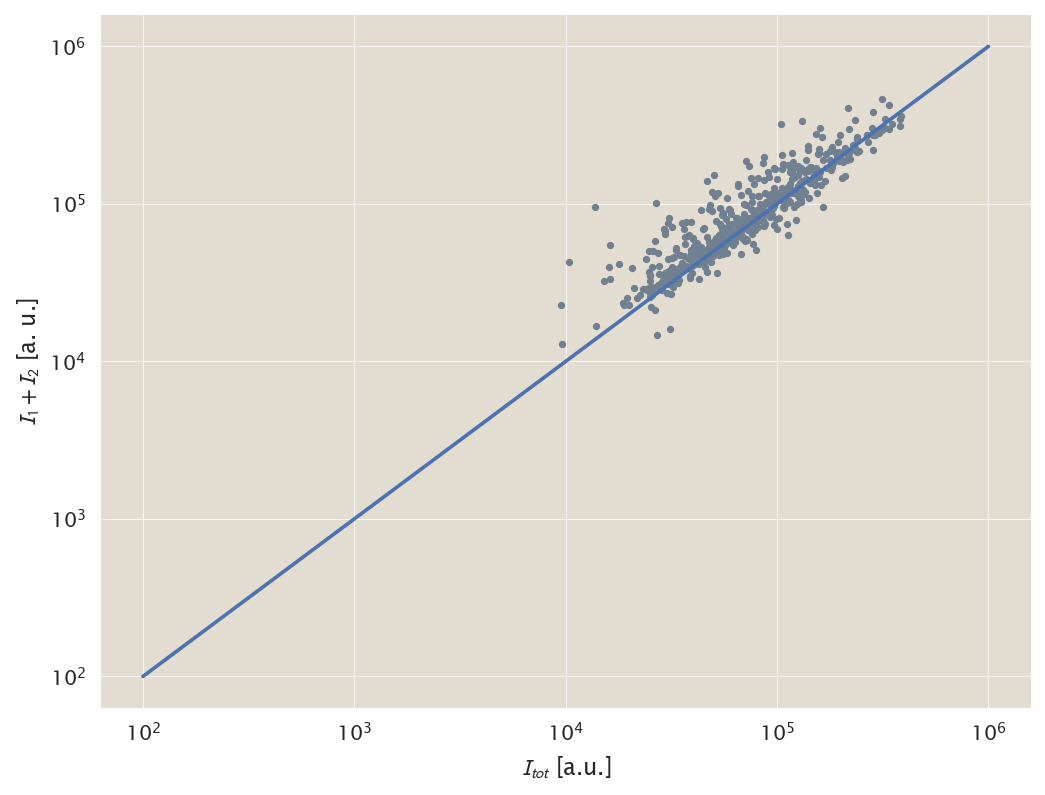

In [24]:
# Make the conservation of fluroescence plot.
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_{tot}$ [a.u.]')
ax.set_ylabel('$I_1 + I_2$ [a. u.]')

I_tot_range = np.logspace(2, 6, 500)
ax.plot(I_tot, (np.array(I_1) + np.array(I_2)), '.', color='slategray')
ax.plot(I_tot_range, I_tot_range, '-')

In [25]:
def deterministic_log_posterior(alpha, I_1, I_2, I_tot, neg=True):
    """
    Computes the log posterior of the deterministic solution to the estimation of the 
    calibration factor value.
    
    Parameters
    ----------
    alpha : float 
        The value of the calibration factor.
    I_1, I_2, I_tot : 1d-arrays or Pandas Series
        The intensity measurements of the daughter cells and the mother cell for a series of division events.
    neg : bool
        If True, the negative log posterior is returned. Default is True.
    
    Returns
    -------
    lp : float
        Value of the log posterior evaluated at the given value of alpha.
    """
    # Determine if the negative log posterior should be returned.
    if neg is True:
        prefactor = -1
    else: 
        prefactor = 1
    # Ensure that the intensity values are not negative.
    if (I_1 <= 0).any() or (I_2 <= 0).any() or (I_tot <= 0).any():
        return ValueError('I_1 and I_2 must be positive.')
    
    # Ensure that alpha is positive.
    if (alpha < 0) | (alpha > 2**16):
        return prefactor * -np.inf
    
    
    # Compute the binomial coefficient.
    n_1 = I_1 / alpha 
    n_2 = I_2 / alpha
    n_tot = I_tot / alpha
    binom = scipy.special.gammaln(n_tot+1).sum() - scipy.special.gammaln(n_1+1).sum() -\
            scipy.special.gammaln(n_2+1).sum()
 
    # Compute the log posterior.
    lp = -len(I_1) * np.log(alpha) + binom - n_tot.sum() * np.log(2)
     
    return prefactor * lp

In [26]:
#  Calculate the calibration factor.
popt = scipy.optimize.minimize_scalar(deterministic_log_posterior, args=(np.array(I_1), np.array(I_2), np.array(I_1) + np.array(I_2)))
alpha_opt = popt.x

In [27]:
alpha_opt

5772.5039073837443

In [28]:
# Bin the data for plotting.
def binning_mean(data, bin_width, sort_values=False):
    """
    Computes the mean value of squared difference and summed intensity of the 
    supplied data with a given number of events per bin. 
    
    Parameters
    ----------
    data : pandas DataFrame
        A dataframe containing the intensities of the daughter cells and the sum
        total intensity.
    bin_width : int
        Number of events to consider per bin.
    sort_values : bool
        If True, the supplied data will be sorted in increasing order of the 
        sum total fluorescence. Default is False.
        
    Returns
    -------
    mean_sq_diff, mean_sum : 1d-arrays
        Arrays of the mean square difference value and the mean summed intensity 
        in a given bin width.  
    """
    # Sort the data if necessary.
    if sort_values:
        data = data.sort_values(by='I_tot')
        
    # Set the bins. 
    bins = np.arange(0, len(data) + bin_width, bin_width)
    
    # Compute the means. 
    mean_sq_diff = [np.mean((data.iloc[bins[i-1]:bins[i]+1]['I_1'] -\
                         data.iloc[bins[i-1]:bins[i]+1]['I_2'])**2) for i in range(1, len(bins))]
    mean_I_tot = [data.iloc[bins[i-1]:bins[i]+1]['I_tot'].mean() for i in range(1, len(bins))] 
    return [np.array(mean_sq_diff), np.array(mean_I_tot)] 

In [31]:
# Set up the data frame.
binning_df = pd.DataFrame(np.array([I_1, I_2, I_tot]).T, columns=['I_1', 'I_2', 'I_tot'])

# Bin the data. 
bin_size = 50
mean_sq_diff, mean_I_tot = binning_mean(binning_df, bin_width=bin_size, sort_values=True)

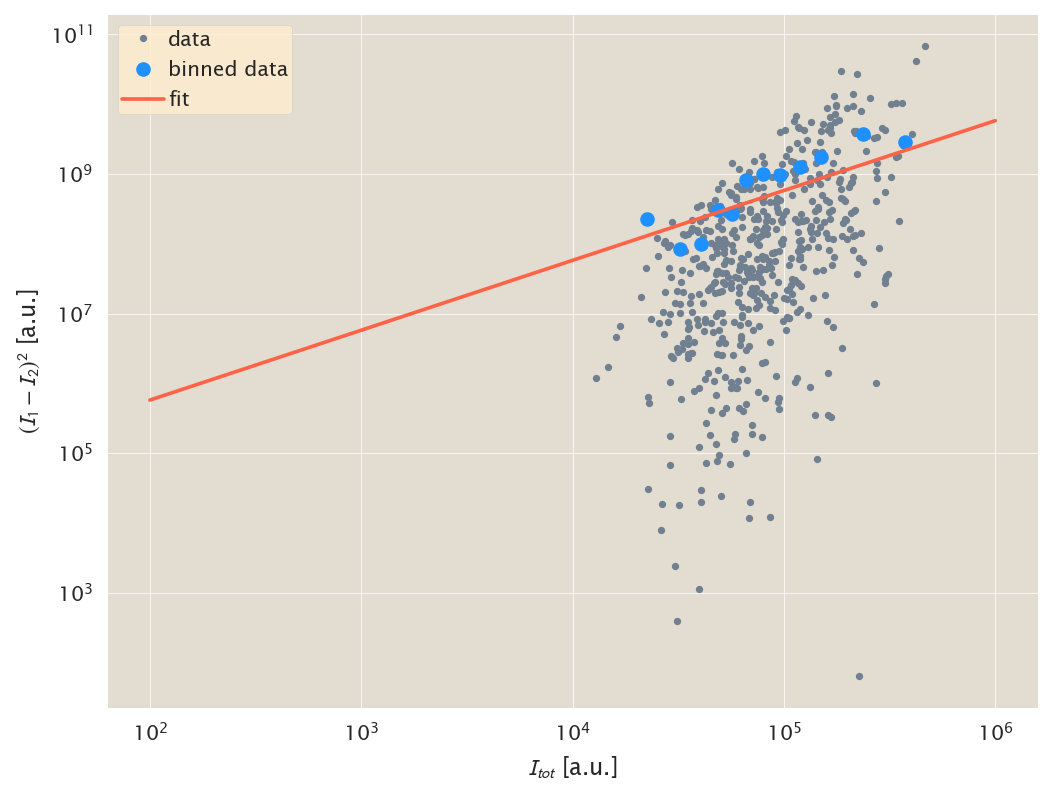

In [32]:
# Make the scatter plot.
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_{tot}$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')

# Plot the data
_ = ax.plot(np.array(I_1) + np.array(I_2), (np.array(I_1) - np.array(I_2))**2, '.', color='slategray', label='data')

# Plot the binned data.
_ = ax.plot(mean_I_tot, mean_sq_diff, 'o', color='dodgerblue', label='binned data')

# Plot the theory curve. 
theo = alpha_opt * I_tot_range
_ = ax.plot(I_tot_range, theo, '-', color='tomato', label='fit')

_ = ax.legend()

## Testing the calibration factor. 

In [33]:
def ecdf(data):
    return np.sort(data), np.arange(0, len(data), 1) / len(data)

deltaTetR dodgerblue
dilution (0.64764321414840453, 0.058961937716262972, 0.082475970780469032)
dilution (0.7971856978085351, 0.095194156093810073, 0.11418685121107267)
dilution (0.93780853517877738, 0.23354094579008075, 0.17393310265282583)
dilution (0.98437524029219525, 0.41814686658977318, 0.29265667051134181)
dilution (0.9882352941176471, 0.57570165321030364, 0.45067281814686661)
dilution (0.98841983852364479, 0.73674740484429058, 0.63589388696655136)
dilution (0.99618608227604766, 0.88069204152249136, 0.82675893886966545)


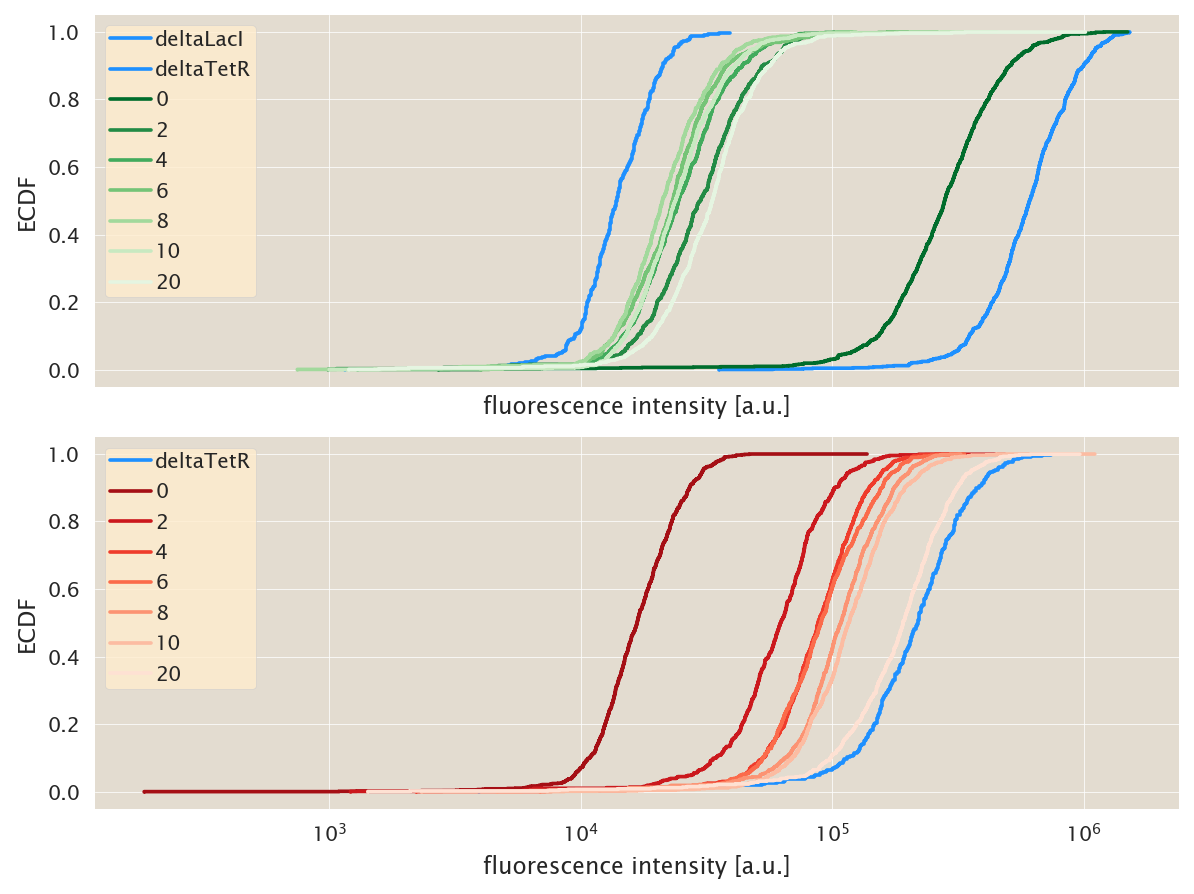

In [34]:
# Plot the various fluorescence distributions.
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_xlabel('fluorescence intensity [a.u.]')
ax[0].set_ylabel('ECDF')
ax[1].set_xlabel('fluorescence intensity [a.u.]')
ax[1].set_ylabel('ECDF')


for a in ax:
    a.set_xscale('log')
     
# Group the data. 
grouped = snap_df.groupby(['strain', 'atc']) 
_yfp_colors = sns.color_palette('Greens_r', n_colors=7)
concs = np.sort(snap_df['atc'].unique())
yfp_colors = {i:j for i, j in zip(concs, _yfp_colors)}
_rfp_colors = sns.color_palette('Reds_r', n_colors=7)
rfp_colors = {i:j for i, j in zip(concs, _rfp_colors)}
for g, d in grouped:
    # Compute the two ECDFs
    YFP_x, YFP_y = ecdf(d['fluor2_birth_fluo'])
    RFP_x, RFP_y = ecdf(d['fluor1_birth_fluo'])
    
    # Figure out the colors
    if (g[0] == 'auto'):
        r_color = 'slategray'
        y_color = 'slategray'
        label = 'auto'
    elif 'delta' in g[0]:
        r_color = 'dodgerblue'
        y_color = 'dodgerblue'
        label = g[0]
    else:
        r_color = rfp_colors[g[1]]
        y_color = yfp_colors[g[1]]
        label = g[1]
        
    # Generate the plot
    if 'deltaLacI' == g[0]:
        _ = ax[0].step(YFP_x, YFP_y, color=y_color, label=label)
#     if 'deltaTetR' == g[0]:
#         _ = ax[1].step(RFP_x, RFP_y, color=y_color, label=label)
    else: 
        _ = ax[0].step(YFP_x, YFP_y, color=y_color, label=label)
        print(g[0], r_color)
        _ = ax[1].step(RFP_x, RFP_y, color=r_color, label=label)

_ = ax[0].legend()
_ = ax[1].legend()

plt.tight_layout()

In [35]:
snap_df[snap_df['strain']=='deltaLacI']

,fluor1_birth_fluo,birth_area,fluor2_birth_fluo,position,strain,atc
1623,21668.0,94.0,380685.0,0,deltaLacI,0
1624,20448.0,80.0,409334.0,0,deltaLacI,0
1625,24106.0,93.0,503403.0,0,deltaLacI,0
1626,18850.0,71.0,615942.0,0,deltaLacI,0
1627,16144.0,76.0,604389.0,0,deltaLacI,0
1628,20322.0,82.0,927585.0,0,deltaLacI,0
1629,14587.0,64.0,803263.0,0,deltaLacI,0
1630,15525.0,73.0,710114.0,0,deltaLacI,0
1631,16133.0,73.0,453365.0,0,deltaLacI,0
1632,9508.0,48.0,413279.0,0,deltaLacI,0


That all makes sense

In [36]:
# Subtract the autofluorescence from each channel.
snap_df.loc[:, 'fluor2_sub'] = snap_df['fluor2_birth_fluo']
snap_df.loc[:, 'fluor1_sub'] = snap_df['fluor1_birth_fluo']

# Compute the mean delta for each.
mean_delta_yfp = snap_df[snap_df['strain']=='deltaLacI']['fluor2_sub'].mean()
mean_delta_cherry = snap_df[snap_df['strain']=='deltaTetR']['fluor1_sub'].mean()

# Look at only the dilution strain and calculate the fold change.
dilution_strain = snap_df[snap_df['strain']=='dilution']
fold_change = []
repressors = []
grouped = dilution_strain.groupby('atc')
for g, d in grouped:
    mean_yfp = d['fluor2_sub'].mean()
    fold_change.append(mean_yfp / mean_delta_yfp)
    mean_repressors = np.mean(d['fluor1_sub'] / alpha_opt)
    repressors.append(mean_repressors)

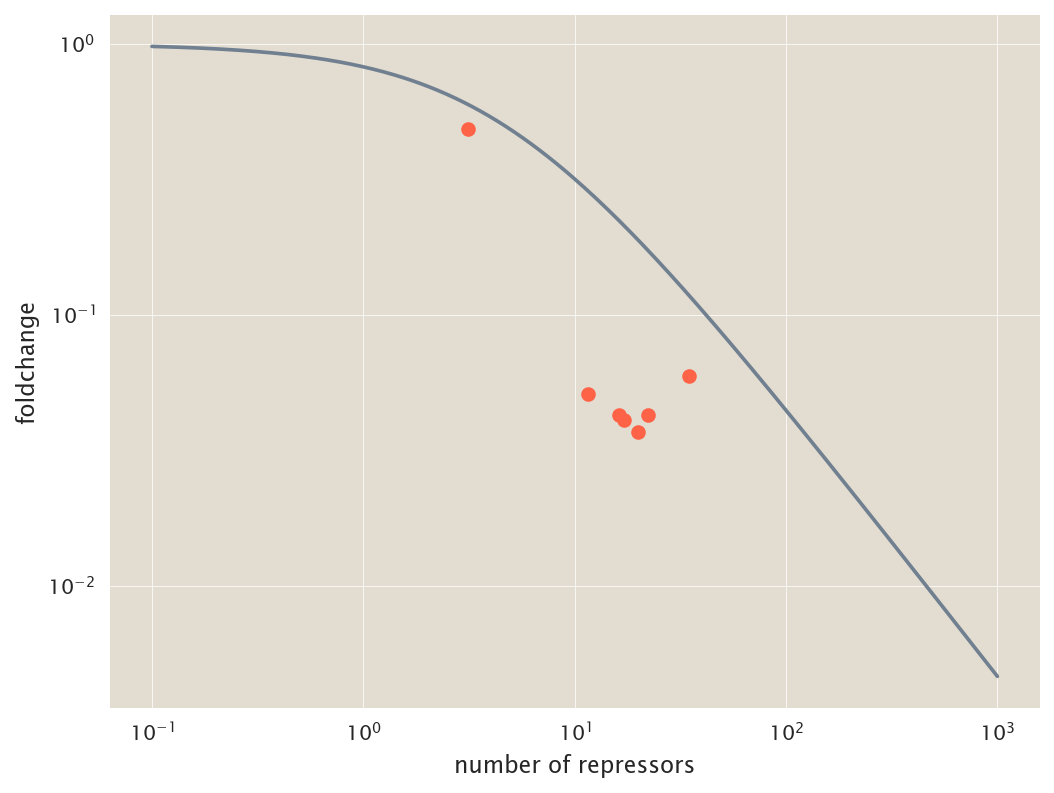

In [38]:
# Compute the prediction.
rep_range = np.logspace(-1, 3, 300)
fc_theo = (1 +  (1 / (1 + np.exp(-4.5))) * (rep_range / 5E6) * np.exp(13.9))**-1

# Generate the plot
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('number of repressors')
ax.set_ylabel('foldchange')
all_fc = dilution_strain['fluor2_sub'] / mean_delta_yfp
all_rep = dilution_strain['fluor1_sub'] / alpha_opt
# Plot the prediction.
_ = ax.plot(rep_range, fc_theo, color='slategray', label='theory')

# Plot the data
_ = ax.plot(np.array(repressors), fold_change, 'o', color='tomato', label='data')
# _ = ax.plot(all_rep, all_fc, ',', color='dodgerblue')


In [399]:
6 * np.array(repressors)

array([   2.86512688,   55.78903557,  190.01025661,  244.99846854,
        289.72898501,  305.0204943 ,  317.24713899])